# Notice

#### This code has been tested in a Colab environment.
#### Please work in a Colab environment if possible.
#### In particular, for problem 2, a GPU is required. Please make sure that the runtime type is set to GPU.

#### Additionally, please do not modify the code outside of the specified sections.

# Install Requried Packages

In [ ]:
# Dataset needed for part 1
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=aefd8bf1a876d70f8eaa649a174553f8a602069a500a5cfb15cdfc0d3fca94bd
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
# Tranformers package for Huggingface
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.8 MB/s eta 0:00:00


In [ ]:
# Dataset package for Huggingface
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.7 MB/s eta 0:00:00


# 1. Question Answering with BERT

In this part, you will load a pre-trained BERT model from hugging face and simply perform a Question Answering Task for wiki data.  
Please fill in the blank parts of the QASystemWithBERT Class.

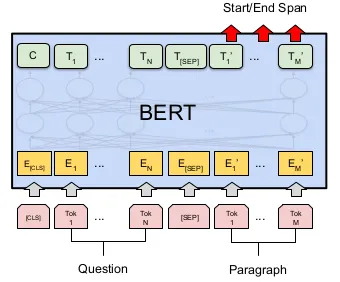

This model takes in a Question and a Reference Passage as inputs, and predicts the starting and ending positions of the sentence that constitutes the answer, generating the response.

### Load required libraries.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from collections import OrderedDict
import torch
import wikipedia as wiki

### QA System Using BERT

##### Your problem start from hear.

You have will solve question 1-1 ~ 1-3 in this section

In [ ]:
class QASystemWithBERT:
    def __init__(self, pretrained_model_name_or_path='bert-large-uncased'):
        self.READER_PATH = pretrained_model_name_or_path

        ## Problem 1-1.

        # Load Tokenizer and model from hugging face.
        # Model path is already provided.
        # your tokenizer should be assigned to 'self.tokenizer' and model to 'self.model'
        # Ref 1 : https://huggingface.co/docs/transformers/main_classes/model
        # Ref 2 : https://huggingface.co/docs/transformers/main_classes/tokenizer
        # HINT : you should use imported methods above.
        #######################YOUR CODE ( ~ 2 lines)#################################
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModelForQuestionAnswering.from_pretrained(pretrained_model_name_or_path)
        ##############################################################################
        self.max_len = self.model.config.max_position_embeddings
        self.chunked = False

    def tokenize(self, question, text):
        self.inputs = self.tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt", return_token_type_ids=True)
        self.input_ids = self.inputs["input_ids"].tolist()[0]


        ## Problem 1-2.

        # Apply self.chunkify function if the length of input is bigger than max length
        # HINT : you also need to change the state of chunked
        ###################### YOUR CODE ( ~3 lines) #################################
        if len(self.input_ids) > self.max_len:
          self.inputs = self.chunkify()
          self.chunked = True
        else:
          self.chunked = False
        #############################################################################

    def chunkify(self):
        """
        Break up a long article into chunks that fit within the max token
        requirement for that Transformer model.
        """
        qmask = self.inputs['token_type_ids'].lt(1)

        qt = torch.masked_select(self.inputs['input_ids'], qmask)
        chunk_size = self.max_len - qt.size()[0] - 1

        chunked_input = OrderedDict()
        for k,v in self.inputs.items():
            q = torch.masked_select(v, qmask)
            c = torch.masked_select(v, ~qmask)
            chunks = torch.split(c, chunk_size)

            for i, chunk in enumerate(chunks):
                if i not in chunked_input:
                    chunked_input[i] = {}

                thing = torch.cat((q, chunk))
                if i != len(chunks)-1:
                    if k == 'input_ids':
                        thing = torch.cat((thing, torch.tensor([102])))
                    else:
                        thing = torch.cat((thing, torch.tensor([1])))

                chunked_input[i][k] = torch.unsqueeze(thing, dim=0)
        return chunked_input

    def get_answer(self):
        if self.chunked:
            answer = ''
            for k, chunk in self.inputs.items():
                answer_start_scores, answer_end_scores = self.model(**chunk)[:2]

                ## Problem 1-3.

                # Assign answer point index for each index to each of the 'answer_start' and 'answer_end'
                # HINT 1 : You need to find the index with the highest score for
                #          both the start and end points of the answer text in order to obtain the answer text.
                # HINT 2 : You should note that in a Python index [A:B], it includes the element at index A and excludes the element at index B.
                #######################YOUR CODE ( ~ 2 lines)#################################
                answer_start = torch.argmax(answer_start_scores)
                answer_end = torch.argmax(answer_end_scores)
                #############################################################################

                ans = self.convert_ids_to_string(chunk['input_ids'][0][answer_start:answer_end])
                if ans != '[CLS]':
                    answer += ans + " / "
            return answer
        else:
            answer_start_scores, answer_end_scores = self.model(**self.inputs)[:2]

            # You can simply insert same code as ## Problem 1-3.
            #######################YOUR CODE ( ~ 2 lines)#################################
            answer_start = torch.argmax(answer_start_scores)
            answer_end = torch.argmax(answer_end_scores)
            #############################################################################

            return self.convert_ids_to_string(self.inputs['input_ids'][0][
                                              answer_start:answer_end])

    def convert_ids_to_string(self, input_ids):
        return self.tokenizer.convert_tokens_to_string(self.tokenizer.convert_ids_to_tokens(input_ids))

### Inference

If you properly filled the blank, the model will answer for your questions!

In [ ]:
questions = [
    'Who is the author of Harry Potter and the Goblet of Fire?',
    'Who is the author of The Lord of the rings'
]


qas = QASystemWithBERT("deepset/bert-base-cased-squad2")


for question in questions:
    print("-------------------------------------")
    print(f"Question: {question}")
    results = wiki.search(question)

    page = wiki.page(results[0])
    print(f"Top wiki result: {page}")

    text = page.content

    qas.tokenize(question, text)
    print(f"Answer: {qas.get_answer()}")
    print("-------------------------------------")

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-------------------------------------
Question: Who is the author of Harry Potter and the Goblet of Fire?
Top wiki result: <WikipediaPage 'Harry Potter and the Goblet of Fire'>


Token indices sequence length is longer than the specified maximum sequence length for this model (3343 > 512). Running this sequence through the model will result in indexing errors


Answer: J. K. Row /  /  /  /  /  /  / 
-------------------------------------
-------------------------------------
Question: Who is the author of The Lord of the rings
Top wiki result: <WikipediaPage 'The Lord of the Rings: The Rings of Power'>
Answer: J. R. R. / J. R. R. /  / [CLS] Who is the author of The Lord of the rings [SEP] between Warner Bros., the studio behind Peter Jackson ' s The Lord of the Rings and The Hobbit film trilogies, and the estate of author J. R. R. /  /  /  /  /  /  /  /  /  / 
-------------------------------------


# 2. Image Captioning Model Fine tuning

In this part, you will load a pre-trained Image Captioning Model "pix2struct" and perform a task that describes an image automatically.   
Additionally, you will conduct fine-tuning on your own data.  
Please fill in the blank parts for each section.

You have will solve question 2-1 ~ 2-5 in each section

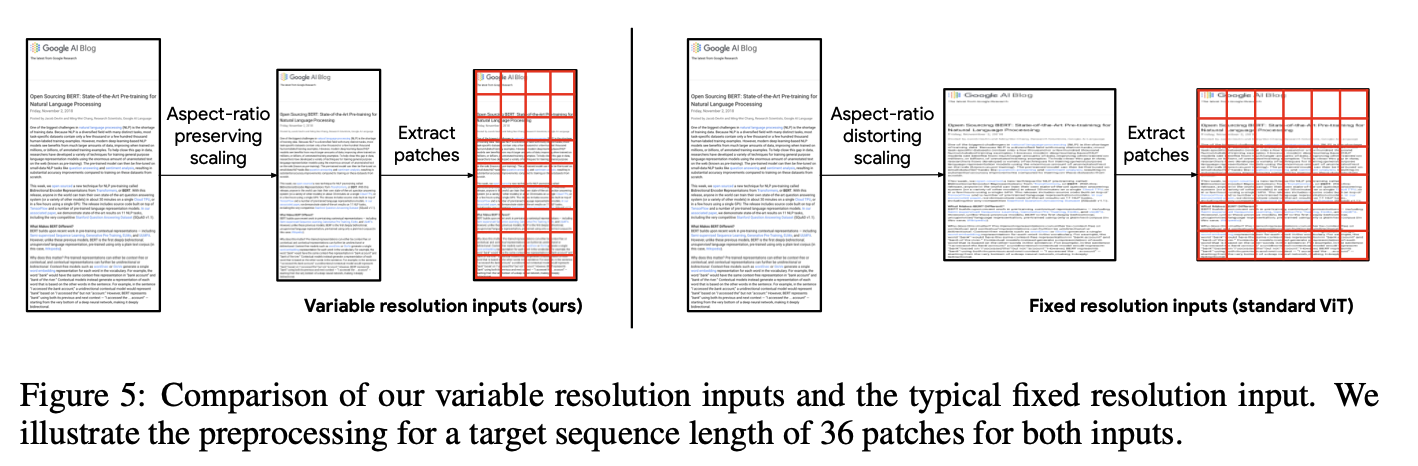

### Load the dataset

Let's load the image captioning dataset, you just need few lines of code for that. The dataset only consists of 6 images that we have manually labeled for the sake of the fine tuning.

In [ ]:
from datasets import load_dataset

## Problem 2-1.

# Load only the training dataset from 'ybelkada/football-dataset' from huggingface to 'dataset' object
# Ref 1 : https://huggingface.co/docs/datasets/loading
# Ref 2 : https://huggingface.co/datasets/ybelkada/football-dataset

#################### YOUR CODE ( ~1 line) #########################
dataset = load_dataset('ybelkada/football-dataset', split='train')
###################################################################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Benzema after Real Mardid's win against PSG


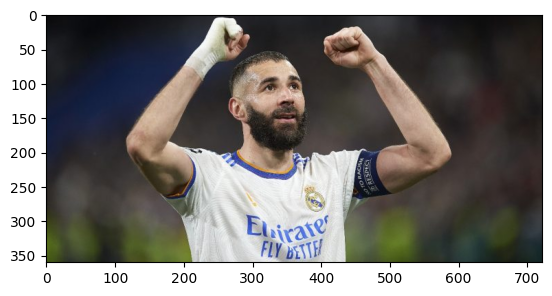



Maradona after winning the 1986 FIFA World Cup with Argentina


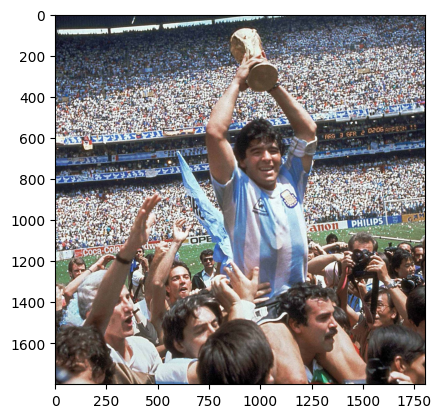



Messi with Argentina at the 2022 FIFA World Cup


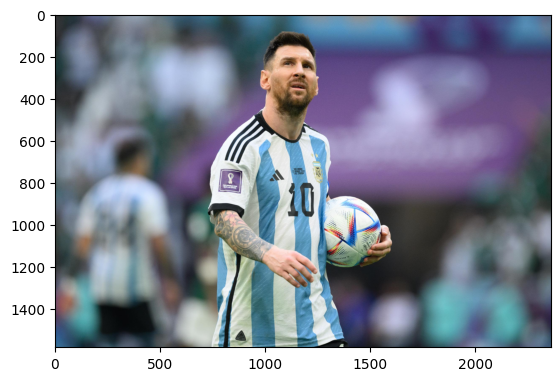



Pirlo with Juventus in 2014


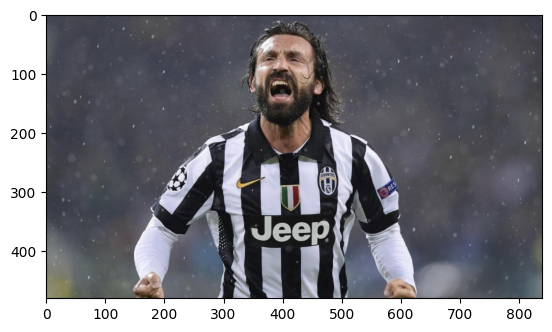



Ronaldo with Portugal at the 2018 World Cup


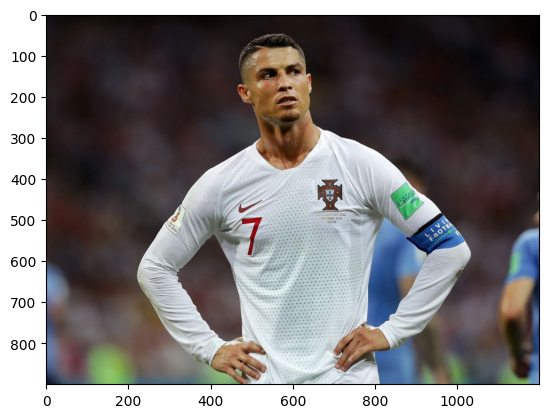



Zidane with France in 2006 World Cup


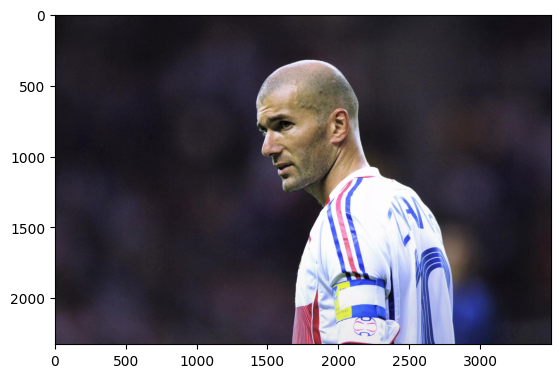

In [ ]:
from matplotlib import pyplot as plt

## Problem 2-2.

# Print the text and image of the dataset.
# Please understand the structure of dataset well.
# HINT : You can use 'print' function for text data and 'plt.imshow' for image data
#################### YOUR CODE ( ~2 line) #########################
for i in range(len(dataset['image'])):
  print(dataset['text'][i])
  plt.imshow(dataset['image'][i])
  plt.show()
  print('\n')
###################################################################

### Load Pre-trained Model

In [ ]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Pix2StructProcessor


## Problem 2-3.

# Load Model and Processor from google/pix2struct-base
# You should load model to 'model' object and processor to 'processor' object
# Ref : https://huggingface.co/google/pix2struct-base
#################### YOUR CODE (~ 2 lines) #########################
processor = Pix2StructProcessor.from_pretrained("google/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base")
######################################################

### Prepare Data for training

In [ ]:
from torch.utils.data import Dataset, DataLoader

MAX_PATCHES = 1024

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)

        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

In [ ]:
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  texts = [item["text"] for item in batch]

  text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=20)

  new_batch["labels"] = text_inputs.input_ids

  for item in batch:
    new_batch["flattened_patches"].append(item["flattened_patches"])
    new_batch["attention_mask"].append(item["attention_mask"])

  new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
  new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

  return new_batch

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

### Fine Tune Model with your own data

If you fine-tune the model properly, the loss will decrease to below 0.5.  
You should be noticed that it will take about 30~60 minitues to complete fine tuning.

In [ ]:
import torch

EPOCHS = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(EPOCHS):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    labels = batch.pop("labels").to(device)
    flattened_patches = batch.pop("flattened_patches").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(flattened_patches=flattened_patches,
                    attention_mask=attention_mask,
                    labels=labels)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

## Problem 2-4.

# Every 20 epochs, print decoded model output.
# Hint 1 : You should stop training before getting model outputs and get back to train mode after print it.
# Hint 2 : You need to get prediction from your model and decode it!
################################# YOUR CODE (~6 lines) ###############################
  if epoch % 20 == 0:
    # 1. 모델을 평가 모드로 전환
    model.eval()

    # 예측 생성
    with torch.no_grad():
        # 시작 토큰을 디코더 입력으로 사용
        decoder_input_ids = torch.full((flattened_patches.shape[0], 1), model.config.decoder_start_token_id, dtype=torch.long).to(device)
        outputs = model(flattened_patches=flattened_patches, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
        logits = outputs.logits

    # 가장 확률이 높은 토큰 ID를 선택
    predicted_ids = torch.argmax(logits, dim=-1)
    decoded_predictions = processor.decode(predicted_ids[0], skip_special_tokens=True)
    print(f"Decoded Output at Epoch {epoch}:", decoded_predictions)

    model.train()
#####################################################################################

Epoch: 0
Loss: 19.117660522460938
Loss: 21.85959243774414
Loss: 19.179786682128906
Decoded Output at Epoch 0: <
Epoch: 1
Loss: 23.661357879638672
Loss: 17.399612426757812
Loss: 20.08586883544922
Epoch: 2
Loss: 23.35238265991211
Loss: 16.213903427124023
Loss: 17.88203239440918
Epoch: 3
Loss: 21.261478424072266
Loss: 22.386943817138672
Loss: 17.793371200561523
Epoch: 4
Loss: 20.250465393066406
Loss: 19.56161117553711
Loss: 18.77686882019043
Epoch: 5
Loss: 14.311161994934082
Loss: 21.5885009765625
Loss: 16.943784713745117
Epoch: 6
Loss: 21.62834358215332
Loss: 17.114545822143555
Loss: 13.49769115447998
Epoch: 7
Loss: 17.498058319091797
Loss: 13.54493236541748
Loss: 19.43994140625
Epoch: 8
Loss: 18.610612869262695
Loss: 16.821657180786133
Loss: 14.384033203125
Epoch: 9
Loss: 16.74018096923828
Loss: 11.380537033081055
Loss: 18.073322296142578
Epoch: 10
Loss: 17.214181900024414
Loss: 15.310846328735352
Loss: 15.852853775024414
Epoch: 11
Loss: 15.152318954467773
Loss: 15.859853744506836
Loss:

### Check your own result.

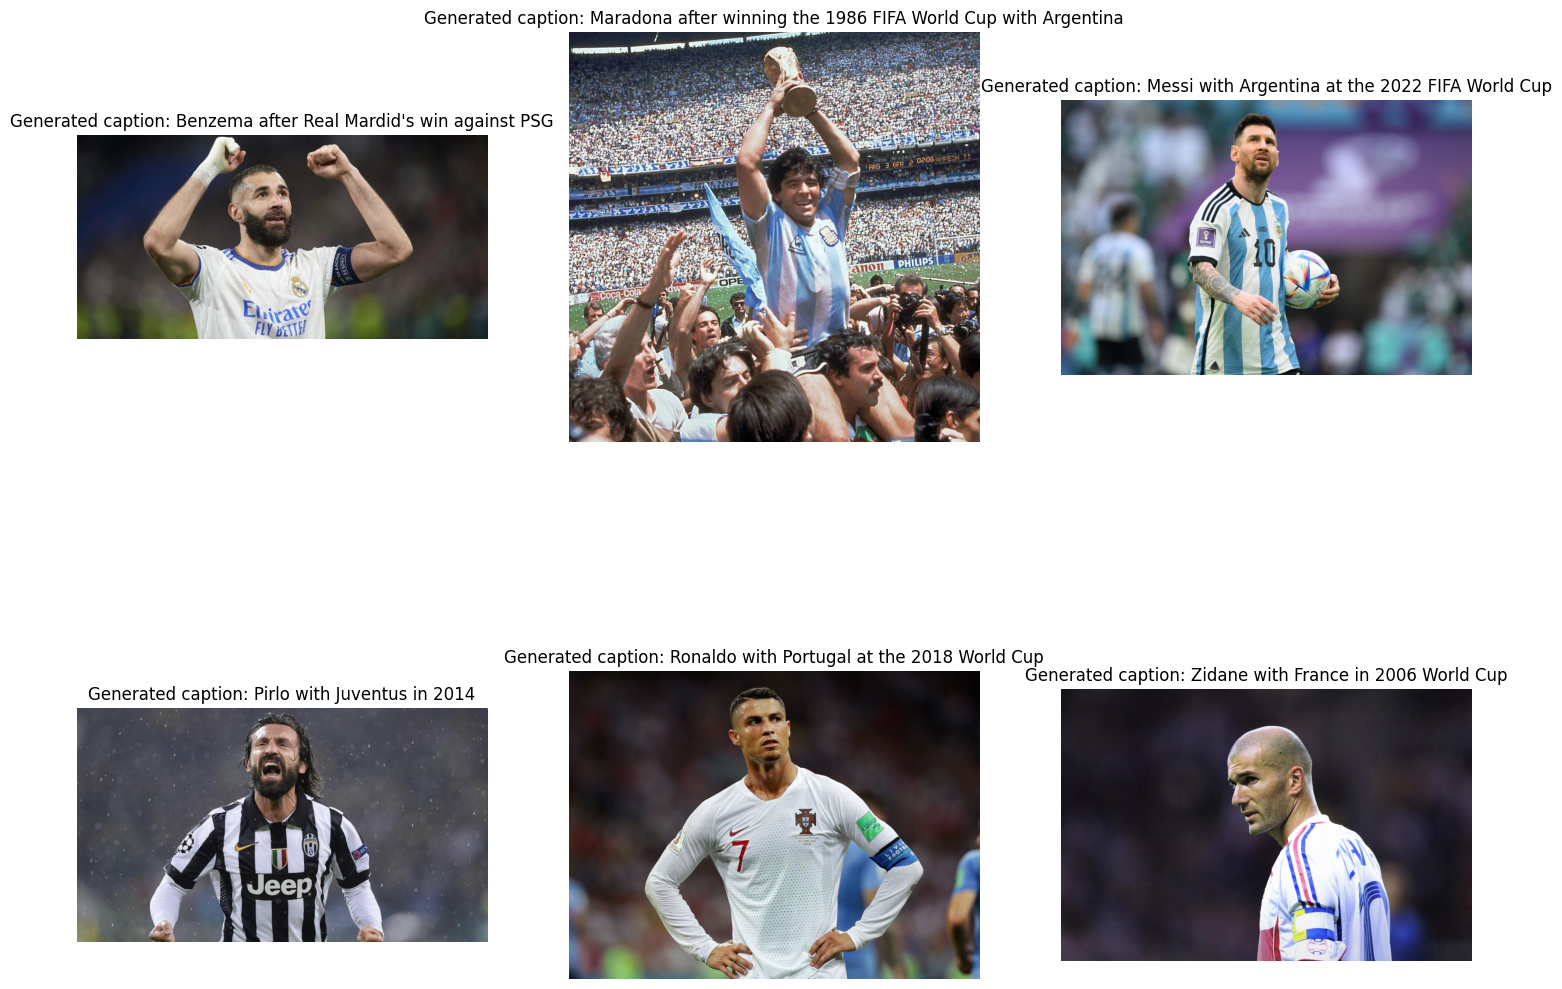

In [ ]:
from matplotlib import pyplot as plt
model.eval()

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt", max_patches=1024).to(device)

  ## Problem 2-5.

  # Get flattened_patches and attention_mask from your inputs.
  # you should asssign flattened_patches to 'flattened_patches' and attention_mask to 'attention_mask' object.
  ###################### YOUR CODE (~2 lines) ######################
  flattened_patches = inputs["flattened_patches"]
  attention_mask = inputs["attention_mask"]
  ##################################################################

  generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")